**IMPORTS**

In [1]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import threading
from threading import Thread
import random
import time
import copy
import multiprocessing


def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=350, blit=True, repeat=False);
  return anim

In [2]:
#Grid size
n = 50
N = n**2
steps = 7

#Starting grid
grid_generated = np.array(np.random.choice([0,1], n**2, p=[0.65, 0.35]))

## **1)**

**a) Threading.Lock**

In [ ]:
grid = copy.deepcopy(grid_generated)
grid = grid.reshape(n, n)

#All matrix iterations
historyGrid = []

#Counters
entry_count = 0
exit_count = N
flag = False

#Locks
ulaz_lock = threading.Lock()
izlaz_lock = threading.Lock()
flag_lock = threading.Lock()
pristup_susedima_lock = threading.Lock()

#Cell class
class Celija(Thread):
  
  def __init__(self, row, col):
    super().__init__()
    self.row = row
    self.col = col
    self.iteration = 0
    self.neighbors_checked = 0
    self.lock = threading.Semaphore(0)

  def checkNeighbors(self):
    total = 0
    x = np.array([0, 0, -1, 1, -1, -1, 1, 1])
    y = np.array([-1, 1, 0, 0, -1, 1, -1, 1])
    
    #Total zivih
    for i in range(0, 8):
      cord_x = self.row + x[i]
      cord_y = self.col + y[i]

      if(cord_x <0 or cord_x >n-1 or cord_y <0 or cord_y > n-1):
        total += 0
      else:
        total += grid[cord_x, cord_y]

      for t in niti:
        if t.row == (self.row + x[i])%n and t.col == (self.col + y[i])%n:
          t.neighbors_checked += 1
        t.lock.release()
    return total
    

  def update(self, zivi):
    global grid
    global exit_count

    if grid[self.row, self.col] == 1:
      if zivi < 2 or zivi > 3:
        grid[self.row, self.col] = 0
    else:
      if zivi == 3:
        grid[self.row, self.col] = 1

    izlaz_lock.acquire()
    exit_count += 1
    print(f"{self.row, self.col}: Update!")
    izlaz_lock.release()
    self.iteration += 1



  def run(self):
      global steps
      global entry_count
      global exit_count
      global flag

      for n in range(0, steps):

        ulaz_lock.acquire()

        if(entry_count == 0):
          while(True):
            time.sleep(0.01)
            izlaz_lock.acquire()
            if(exit_count == N):
              entry_count += 1
              flag_lock.acquire()
              flag = False
              historyGrid.append(grid.copy())
              flag_lock.release()
              izlaz_lock.release()
              print(f"{entry_count} - POCETAK")
              break
            else:
              izlaz_lock.release()
        else:
          flag_lock.acquire()
          if(flag == False):
            entry_count += 1
            if(entry_count == N):
              print(f"{entry_count} - SVI USLI!!!")
              flag = True
              entry_count = 0
              izlaz_lock.acquire()
              exit_count = 0
              izlaz_lock.release()
              flag_lock.release()
            else:
              flag_lock.release()
        
        ulaz_lock.release() 
        
        zivi_susedi = self.checkNeighbors()
        while True:
          self.lock.acquire()
          pristup_susedima_lock.acquire()
          #print(f"{self.row, self.col}: {self.neighbors_checked}" )
          if (self.neighbors_checked == 8):
            self.neighbors_checked = 0
            pristup_susedima_lock.release()
            print(f"{self.row, self.col} : FINISHED")
            break
          pristup_susedima_lock.release()
        

        #Celije cekaju da flag bude postavljen na True da bi mogle da izadju
        while True:
          time.sleep(0.01)
          flag_lock.acquire()
          print(f"{self.row, self.col}: CEKAM")
          if(flag == True):
            
            self.update(zivi_susedi)
            flag_lock.release_lock()
            break
          else:
            flag_lock.release()
            
niti = []

for i in range(0, n):
  for j in range(0, n):
    nit = Celija(i, j)
    niti.append(nit)

for t in niti:
  t.start()

for t in niti:
  t.join()

anim = animate(historyGrid)
HTML(anim.to_html5_video())

**b) CONDITION**

In [ ]:
grid = copy.deepcopy(grid_generated)
grid = grid.reshape(n, n)

#All matrix iterations
historyGrid = []

#Counters
exit_count = 0

#Locks
izlaz_lock = threading.Lock()
flag_lock = threading.Condition()
pristup_susedima_lock = threading.Lock()

#Cell class
class CelijaCondition(Thread):
  
  def __init__(self, row, col):
    super().__init__()
    self.row = row
    self.col = col
    self.iteration = 0
    self.neighbors_checked = 0
    self.lock = threading.Semaphore(0)

  def checkNeighbors(self):
    total = 0
    x = np.array([0, 0, -1, 1, -1, -1, 1, 1])
    y = np.array([-1, 1, 0, 0, -1, 1, -1, 1])
    
    #Total zivih
    for i in range(0, 8):
      
      cord_x = self.row + x[i]
      cord_y = self.col + y[i]

      if(cord_x <0 or cord_x >n-1 or cord_y <0 or cord_y > n-1):
        total += 0
      else:
        total += grid[self.row + x[i], self.col + y[i]]

      for t in niti:
        if t.row == (self.row + x[i])%n and t.col == (self.col + y[i])%n:
          t.neighbors_checked += 1
        t.lock.release()
    
    return total
    

  def update(self, zivi):
    global grid
    global exit_count

    if grid[self.row, self.col] == 1:
      if zivi < 2 or zivi > 3:
        grid[self.row, self.col] = 0
    else:
      if zivi == 3:
        grid[self.row, self.col] = 1

    izlaz_lock.acquire()
    exit_count += 1
    print(f"{self.row, self.col}: Update!")
    izlaz_lock.release()

    self.iteration += 1



  def run(self):
      global steps
      global exit_count

      for p in range(0, steps):
        zivi_susedi = self.checkNeighbors()
        while True:
          self.lock.acquire()
          pristup_susedima_lock.acquire()
          if (self.neighbors_checked == 8):
            self.neighbors_checked = 0
            pristup_susedima_lock.release()
            print(f"{self.row, self.col} : FINISHED")
            break
          pristup_susedima_lock.release()

        time.sleep(0.01)

        self.update(zivi_susedi)

        izlaz_lock.acquire()
        if exit_count == N:
          exit_count = 0
          izlaz_lock.release()
          flag_lock.acquire()
          flag_lock.notify_all()
          flag_lock.release()
          historyGrid.append(grid.copy())
        else:
          izlaz_lock.release()
          flag_lock.acquire()
          flag_lock.wait()
          flag_lock.release()



niti = []

for i in range(0, n):
  for j in range(0, n):
    nit = CelijaCondition(i, j)
    niti.append(nit)

for t in niti:
  t.start()

for t in niti:
  t.join()

anim = animate(historyGrid)
HTML(anim.to_html5_video())

**c)** ***BARRIER***

In [ ]:
grid = copy.deepcopy(grid_generated)
grid = grid.reshape(n, n)

#All matrix iterations
historyGrid = []

#Locks
barrier_lock = threading.Barrier(N)
pristup_susedima_lock = threading.Lock()

#Cell class
class CelijaBarrier(Thread):
  
  def __init__(self, row, col):
    super().__init__()
    self.row = row
    self.col = col
    self.iteration = 0
    self.neighbors_checked = 0
    self.lock = threading.Semaphore(0)

  def checkNeighbors(self):
    total = 0
    x = np.array([0, 0, -1, 1, -1, -1, 1, 1])
    y = np.array([-1, 1, 0, 0, -1, 1, -1, 1])
    
    #Total zivih
    for i in range(0, 8):
      
      cord_x = self.row + x[i]
      cord_y = self.col + y[i]

      if(cord_x <0 or cord_x >n-1 or cord_y <0 or cord_y > n-1):
        total += 0
      else:
        total += grid[self.row + x[i], self.col + y[i]]

      for t in niti:
        if t.row == (self.row + x[i])%n and t.col == (self.col + y[i])%n:
          t.neighbors_checked += 1
        t.lock.release()
    
    return total
    

  def update(self, zivi):
    global grid
    

    if grid[self.row, self.col] == 1:
      if zivi < 2 or zivi > 3:
        grid[self.row, self.col] = 0
    else:
      if zivi == 3:
        grid[self.row, self.col] = 1


    self.iteration += 1



  def run(self):
      global steps
      global exit_count

      for p in range(0, steps):
        zivi_susedi = self.checkNeighbors()
        while True:
          self.lock.acquire()
          pristup_susedima_lock.acquire()
          if (self.neighbors_checked == 8):
            self.neighbors_checked = 0
            pristup_susedima_lock.release()
            print(f"{self.row, self.col} : FINISHED")
            break
          pristup_susedima_lock.release()

        time.sleep(0.01)

        self.update(zivi_susedi)

        time.sleep(0.01)

        remaining = barrier_lock.wait()
        if(remaining == 0):
          historyGrid.append(grid.copy())



niti = []

for i in range(0, n):
  for j in range(0, n):
    nit = CelijaBarrier(i, j)
    niti.append(nit)

for t in niti:
  t.start()

for t in niti:
  t.join()

anim = animate(historyGrid)
HTML(anim.to_html5_video())

## **2)**

## **3)**

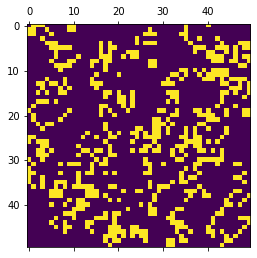

In [3]:
N = 5 # Konfigurabilni parametar

grid = copy.deepcopy(grid_generated)
grid = grid.reshape(n, n)

def cell_subset_func(task, grid, n):
    koordinate = {}
    
    for x, y in task:
        
        dx = [0, 1, 1, 1, 0, -1, -1, -1]
        dy = [1, 1, 0, -1, -1, -1, 0, 1]
        
        zivi_susedi = 0
        
        for i in range(8):

          cord_x = x + dx[i]
          cord_y = y + dy[i]

          if(cord_x <0 or cord_x >n-1 or cord_y <0 or cord_y > n-1):
            zivi_susedi += 0
          else:
            zivi_susedi += grid[x + dx[i], y + dy[i]]
            
        if grid[x, y] == 1:
            if zivi_susedi < 2 or zivi_susedi > 3:
                koordinate[(x, y)] = 0
            else:
                koordinate[(x, y)] = 1
        else:
            if zivi_susedi == 3:
                koordinate[(x,y)] = 1
            else:
                koordinate[(x,y)] = 0
    
    return koordinate
    

if __name__ == '__main__':
    matrix_history = [grid.copy()]
    tasks = []
    results = []
    broj_delova = (n**2)//N
    # Dodavanje podskupa celija u posebne taskove
    
    
    cell_subset = []
    counter = 0
    index = 0
    for i in range(0, n):
        for j in range(0, n):
            cell_subset.append((i, j))
            counter += 1
            if counter == broj_delova:
                temp = cell_subset
                tasks.insert(index, temp)
                index += 1
                counter = 0
                cell_subset = []
    
    if len(cell_subset) != 0:
        tasks.insert(index, cell_subset)

    # Process pool
    pool = multiprocessing.Pool(4)
    

    for i in range(steps):
        results = [pool.apply(cell_subset_func, args=(task, grid, n,)) for task in tasks]
        
        for r in results:
            for k, v in r.items():
                grid[k[0], k[1]] = v
                
        matrix_history.append(grid.copy())
    
    pool.close()
    pool.join()

anim = animate(matrix_history)
HTML(anim.to_html5_video())